In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
# Standard machine learning models
from sklearn.linear_model import LogisticRegressionCV

# Scikit-learn utilities
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve

In [2]:
# PyMC3 for Bayesian Inference
import pymc3 as pm
print(pm.__version__)
import arviz

3.11.4


In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn-darkgrid')
from IPython.core.pylabtools import figsize
import matplotlib.lines as mlines

import seaborn as sns
import itertools

pd.options.mode.chained_assignment = None


from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
data = pd.read_csv(r"heart-2.csv")
#first few rows
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Data Exploration

In [5]:
print ("Rows     : " ,data.shape[0])
print ("Columns  : " ,data.shape[1])
print ("\nFeatures : \n" ,data.columns.tolist())
print ("\nMissing values :  ", data.isnull().sum().values.sum())
print ("\nUnique values :  \n",data.nunique())

Rows     :  918
Columns  :  12

Features : 
 ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']

Missing values :   0

Unique values :  
 Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64


Feature Engineering

In [6]:
for i in data.columns:
    if len(data[i].unique())<10:
        print("Column:{},Unique values:{}".format(i,data[i].unique()))
    else:
        print("Column:{}Unique values:{}".format(i,len(data[i].unique())))

Column:AgeUnique values:50
Column:Sex,Unique values:['M' 'F']
Column:ChestPainType,Unique values:['ATA' 'NAP' 'ASY' 'TA']
Column:RestingBPUnique values:67
Column:CholesterolUnique values:222
Column:FastingBS,Unique values:[0 1]
Column:RestingECG,Unique values:['Normal' 'ST' 'LVH']
Column:MaxHRUnique values:119
Column:ExerciseAngina,Unique values:['N' 'Y']
Column:OldpeakUnique values:53
Column:ST_Slope,Unique values:['Up' 'Flat' 'Down']
Column:HeartDisease,Unique values:[0 1]


Preparing dataframe for ML related algoithms by changing categorical variable in to dummies variable and changing "YES"/"NO" to 1/0 columns respectively

In [7]:
data_dummies=pd.DataFrame()
print("Total number of rows before starting copying:{}".format(len(data_dummies)))
data_dummies = pd.get_dummies(data[['Sex','ChestPainType','RestingECG']], columns=['Sex','ChestPainType','RestingECG'])
data_dummies['ExerciseAngina'] =data['ExerciseAngina']
data_dummies['ST_Slope'] = data['ST_Slope'].map(lambda s :1  if s =='Up' else 0)
data_dummies['ExerciseAngina'] = data['ExerciseAngina'].map(lambda s :1  if s =='Y' else 0)
data_dummies['RestingECG'] = data['RestingECG'].map(lambda s :1  if s =='ST' else 0)
data_dummies['Sex'] = data['Sex'].map(lambda s :1  if s =='M' else 0)
data_dummies['ChestPainType'] = data['ChestPainType'].map(lambda s :1  if s =='ATA' else 0)
data_dummies['RestingBP']=data['RestingBP']
data_dummies['Cholesterol']=data['Cholesterol']
data_dummies['MaxHR']=data['MaxHR']

print("Total number of rows after  copying:{}".format(len(data_dummies)))
      #Counting number of na
print("Number of NA")
print(len(data_dummies) - data_dummies.count())
data_dummies.dropna(axis=0,inplace=True)
print("Total number of rows after removing NA:{}".format(len(data_dummies)))
data_dummies['HeartDisease']=data['HeartDisease']                     

data_dummies.columns
data_dummies.head()

Total number of rows before starting copying:0
Total number of rows after  copying:918
Number of NA
Sex_F                0
Sex_M                0
ChestPainType_ASY    0
ChestPainType_ATA    0
ChestPainType_NAP    0
ChestPainType_TA     0
RestingECG_LVH       0
RestingECG_Normal    0
RestingECG_ST        0
ExerciseAngina       0
ST_Slope             0
RestingECG           0
Sex                  0
ChestPainType        0
RestingBP            0
Cholesterol          0
MaxHR                0
dtype: int64
Total number of rows after removing NA:918


,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina,ST_Slope,RestingECG,Sex,ChestPainType,RestingBP,Cholesterol,MaxHR,HeartDisease
0,0,1,0,1,0,0,0,1,0,0,1,0,1,1,140,289,172,0
1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,160,180,156,1
2,0,1,0,1,0,0,0,0,1,0,1,1,1,1,130,283,98,0
3,1,0,1,0,0,0,0,1,0,1,0,0,0,0,138,214,108,1
4,0,1,0,0,1,0,0,1,0,0,1,0,1,0,150,195,122,0


In [8]:
print("Checking if columns are ready to apply ML algorithm")
for i in data_dummies.columns:
    if len(data_dummies[i].unique())<10:
        print("Column:{},Unique values:{},Type:{}".format(i,data_dummies[i].unique(),data_dummies[i].dtypes))
    else:
        print("Column:{}Unique values:{},Type:{}".format(i,len(data_dummies[i].unique()),data_dummies[i].dtypes))

Checking if columns are ready to apply ML algorithm
Column:Sex_F,Unique values:[0 1],Type:uint8
Column:Sex_M,Unique values:[1 0],Type:uint8
Column:ChestPainType_ASY,Unique values:[0 1],Type:uint8
Column:ChestPainType_ATA,Unique values:[1 0],Type:uint8
Column:ChestPainType_NAP,Unique values:[0 1],Type:uint8
Column:ChestPainType_TA,Unique values:[0 1],Type:uint8
Column:RestingECG_LVH,Unique values:[0 1],Type:uint8
Column:RestingECG_Normal,Unique values:[1 0],Type:uint8
Column:RestingECG_ST,Unique values:[0 1],Type:uint8
Column:ExerciseAngina,Unique values:[0 1],Type:int64
Column:ST_Slope,Unique values:[1 0],Type:int64
Column:RestingECG,Unique values:[0 1],Type:int64
Column:Sex,Unique values:[1 0],Type:int64
Column:ChestPainType,Unique values:[1 0],Type:int64
Column:RestingBPUnique values:67,Type:int64
Column:CholesterolUnique values:222,Type:int64
Column:MaxHRUnique values:119,Type:int64
Column:HeartDisease,Unique values:[0 1],Type:int64


Test Train data prep:

In [9]:
y = data_dummies['HeartDisease'].values
X = data_dummies.loc[:, data_dummies.columns != 'HeartDisease']
from sklearn.preprocessing import MinMaxScaler
features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

Modelling and learning:

In [10]:
 #Calculate the accuracy and f1 score of a model
def calc_metrics(predictions, y_test):
    accuracy = np.mean(predictions == y_test)
    f1_metric = f1_score(y_test, predictions)

    print('Accuracy of Model: {:.2f}%'.format(100 * accuracy))
    print('F1 Score of Model: {:.4f}'.format(f1_metric))
baseline_pred = [0 for _ in range(len(y_test))]
calc_metrics(baseline_pred, y_test)

Accuracy of Model: 44.20%
F1 Score of Model: 0.0000


In [11]:
lr = LogisticRegressionCV(Cs= 20, cv = 3, scoring = 'f1', 
                          penalty = 'l2', random_state = 42)
lr.fit(X_test, y_test)

# Make predictions and evaluate
lr_pred = lr.predict(X_test)
calc_metrics(lr_pred, y_test)

Accuracy of Model: 84.42%
F1 Score of Model: 0.8626


Bayesean Modelling

In [12]:
# Build up a formula
formula = [' %s + ' % variable for variable in X_test.columns]
formula.insert(0, 'y ~ ')
formula = ' '.join(''.join(formula).split(' ')[:-2])
formula

'y ~  Sex_F +  Sex_M +  ChestPainType_ASY +  ChestPainType_ATA +  ChestPainType_NAP +  ChestPainType_TA +  RestingECG_LVH +  RestingECG_Normal +  RestingECG_ST +  ExerciseAngina +  ST_Slope +  RestingECG +  Sex +  ChestPainType +  RestingBP +  Cholesterol +  MaxHR'

In [13]:
print('Intercept: {:0.4f}'.format(lr.intercept_[0]))
for feature, weight in zip(X_test.columns, lr.coef_[0]):
    print('Feature: {:30} Weight: {:0.4f}'.format(feature, weight))

Intercept: 0.8521
Feature: Sex_F                          Weight: -0.6059
Feature: Sex_M                          Weight: 0.6060
Feature: ChestPainType_ASY              Weight: 0.7553
Feature: ChestPainType_ATA              Weight: -0.3527
Feature: ChestPainType_NAP              Weight: -0.4757
Feature: ChestPainType_TA               Weight: 0.0732
Feature: RestingECG_LVH                 Weight: 0.3352
Feature: RestingECG_Normal              Weight: -0.2152
Feature: RestingECG_ST                  Weight: -0.1199
Feature: ExerciseAngina                 Weight: 0.9416
Feature: ST_Slope                       Weight: -1.8634
Feature: RestingECG                     Weight: -0.1199
Feature: Sex                            Weight: 0.6060
Feature: ChestPainType                  Weight: -0.3527
Feature: RestingBP                      Weight: -0.0461
Feature: Cholesterol                    Weight: -1.1275
Feature: MaxHR                          Weight: -1.1783


In [14]:
X_with_labels = X_train.copy()
X_with_labels['y'] = y_train
with pm.Model() as logistic_model:
    priors=dict()
    
    for variable in X_test.columns:
        priors[variable]=pm.Uniform.dist(0,1)
    priors['RestingBP']=pm.Normal.dist(mu=0., sigma=100.)
    priors['Cholesterol']=pm.Normal.dist(mu=0., sigma=100.)
    priors['MaxHR'] = pm.Normal.dist(mu=0., sigma=100.)
    # Build the model using the formula and specify the data likelihood 
    pm.GLM.from_formula(formula, data = X_with_labels, family = pm.glm.families.Binomial(),priors=priors)
    
    # Using the no-uturn sampler
    sampler = pm.NUTS()

    #sampler = pm.Metropolis()
    
    # Sample from the posterior using NUTS
    trace_log = pm.sample(draws=2000, step = sampler, chains=1, tune=1000, random_seed=100,init='adapt_diag')

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (1 chains in 1 job)
NUTS: [MaxHR, Cholesterol, RestingBP, ChestPainType, Sex, RestingECG, ST_Slope, ExerciseAngina, RestingECG_ST, RestingECG_Normal, RestingECG_LVH, ChestPainType_TA, ChestPainType_NAP, ChestPainType_ATA, ChestPainType_ASY, Sex_M, Sex_F, Intercept]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 62 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [16]:
X_with_labels = X_train.copy()
X_with_labels['y'] = y_train
with pm.Model() as logistic_model:
    priors=dict()
    
    for variable in X_test.columns:
        priors[variable]=pm.Uniform.dist(0,1)
    priors['RestingBP']=pm.Normal.dist(mu=0., sigma=100.)
    priors['Cholesterol']=pm.Normal.dist(mu=0., sigma=100.)
    priors['MaxHR'] = pm.Normal.dist(mu=0., sigma=100.)
    # Build the model using the formula and specify the data likelihood 
    pm.GLM.from_formula(formula, data = X_with_labels, family = pm.glm.families.Binomial(),priors=priors)
    
    # Using the no-uturn sampler
    #sampler = pm.NUTS()

    sampler = pm.Metropolis()
    
    # Sample from the posterior using NUTS
    trace_log_MH = pm.sample(draws=2000, step = sampler, chains=1, tune=1000, random_seed=100,init='adapt_diag')

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [MaxHR]
>Metropolis: [Cholesterol]
>Metropolis: [RestingBP]
>Metropolis: [ChestPainType]
>Metropolis: [Sex]
>Metropolis: [RestingECG]
>Metropolis: [ST_Slope]
>Metropolis: [ExerciseAngina]
>Metropolis: [RestingECG_ST]
>Metropolis: [RestingECG_Normal]
>Metropolis: [RestingECG_LVH]
>Metropolis: [ChestPainType_TA]
>Metropolis: [ChestPainType_NAP]
>Metropolis: [ChestPainType_ATA]
>Metropolis: [ChestPainType_ASY]
>Metropolis: [Sex_M]
>Metropolis: [Sex_F]
>Metropolis: [Intercept]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 42 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [38]:
X_with_labels = X_train.copy()
X_with_labels['y'] = y_train
with pm.Model() as logistic_model1:
    priors=dict()
    
    for variable in X_test.columns:
        priors[variable]=pm.Uniform.dist(0,1)
    priors['RestingBP']=pm.Normal.dist(mu=0., sigma=100.)
    priors['Cholesterol']=pm.Normal.dist(mu=0., sigma=100.)
    #priors['MaxHR'] = pm.Normal.dist(mu=0., sigma=100.)
    # Build the model using the formula and specify the data likelihood 
    pm.GLM.from_formula(formula, data = X_with_labels, family = pm.glm.families.Binomial(),priors=priors)
    
    # Using the no-uturn sampler
    sampler = pm.NUTS()

    #sampler = pm.Metropolis()
    
    # Sample from the posterior using NUTS
    trace_log_NU_1 = pm.sample(draws=2000, step = sampler, chains=1, tune=1000, random_seed=100,init='adapt_diag')

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
Sequential sampling (1 chains in 1 job)
NUTS: [MaxHR, Cholesterol, RestingBP, ChestPainType, Sex, RestingECG, ST_Slope, ExerciseAngina, RestingECG_ST, RestingECG_Normal, RestingECG_LVH, ChestPainType_TA, ChestPainType_NAP, ChestPainType_ATA, ChestPainType_ASY, Sex_M, Sex_F, Intercept]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 77 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [17]:
import pickle
fileObject = open("all_parameters.pickle",'wb')  
pickle.dump(trace_log, fileObject)
fileObject.close()

In [18]:
trace_log_from_file= pickle.load(open("all_parameters.pickle",'rb')  )
#trace_log=trace_log_from_file   #Uncomment this line if we don't want to run model again

Got error No model on context stack. trying to find log_likelihood in translation.


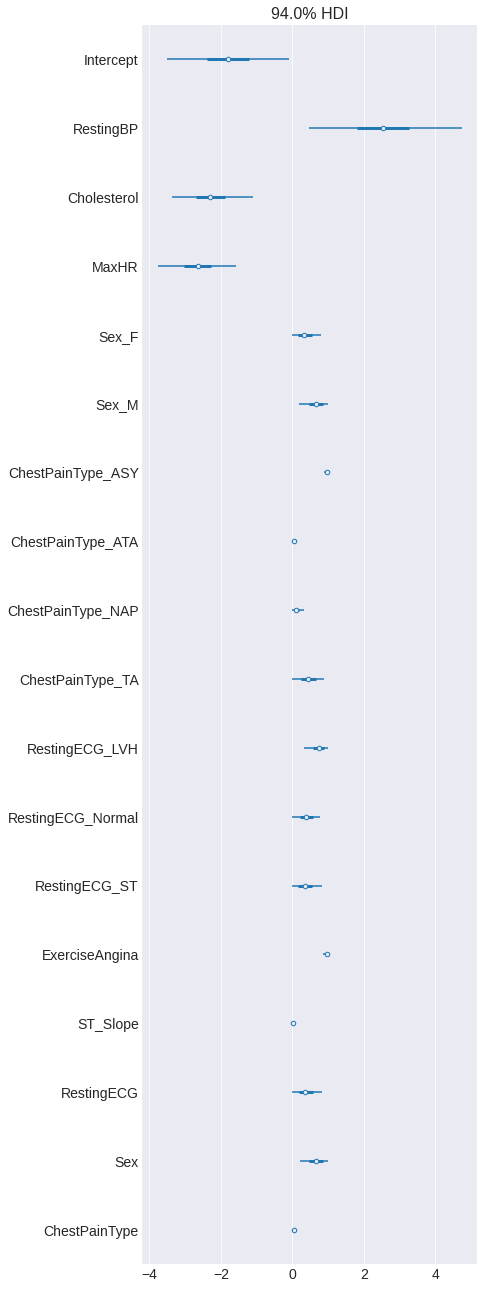

In [19]:
figsize(10, 12)
pm.forestplot(trace_log);

Got error No model on context stack. trying to find log_likelihood in translation.


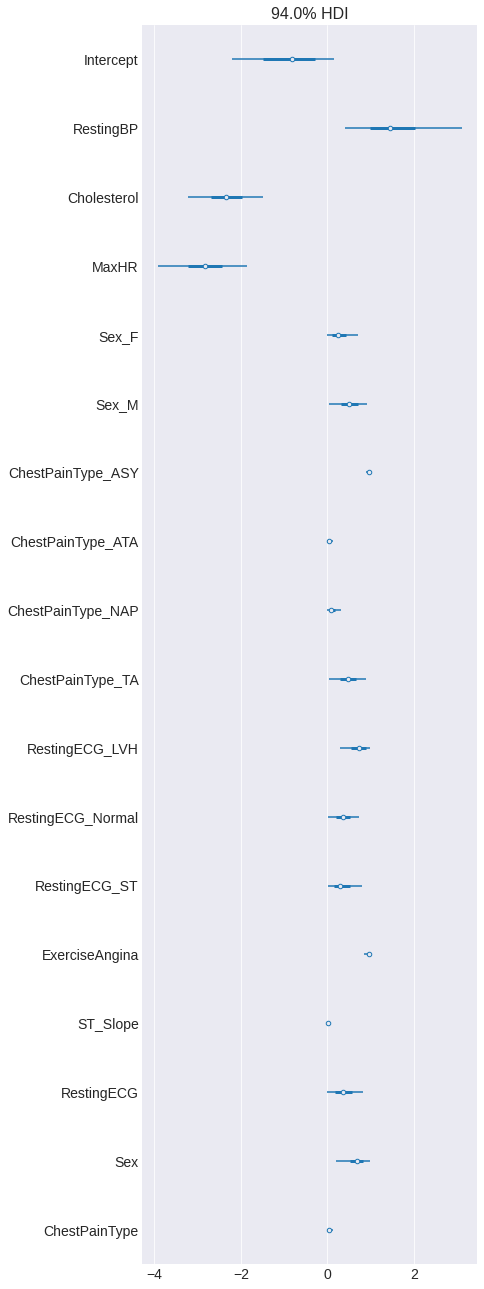

In [20]:
figsize(10, 12)
pm.forestplot(trace_log_MH);

Got error No model on context stack. trying to find log_likelihood in translation.


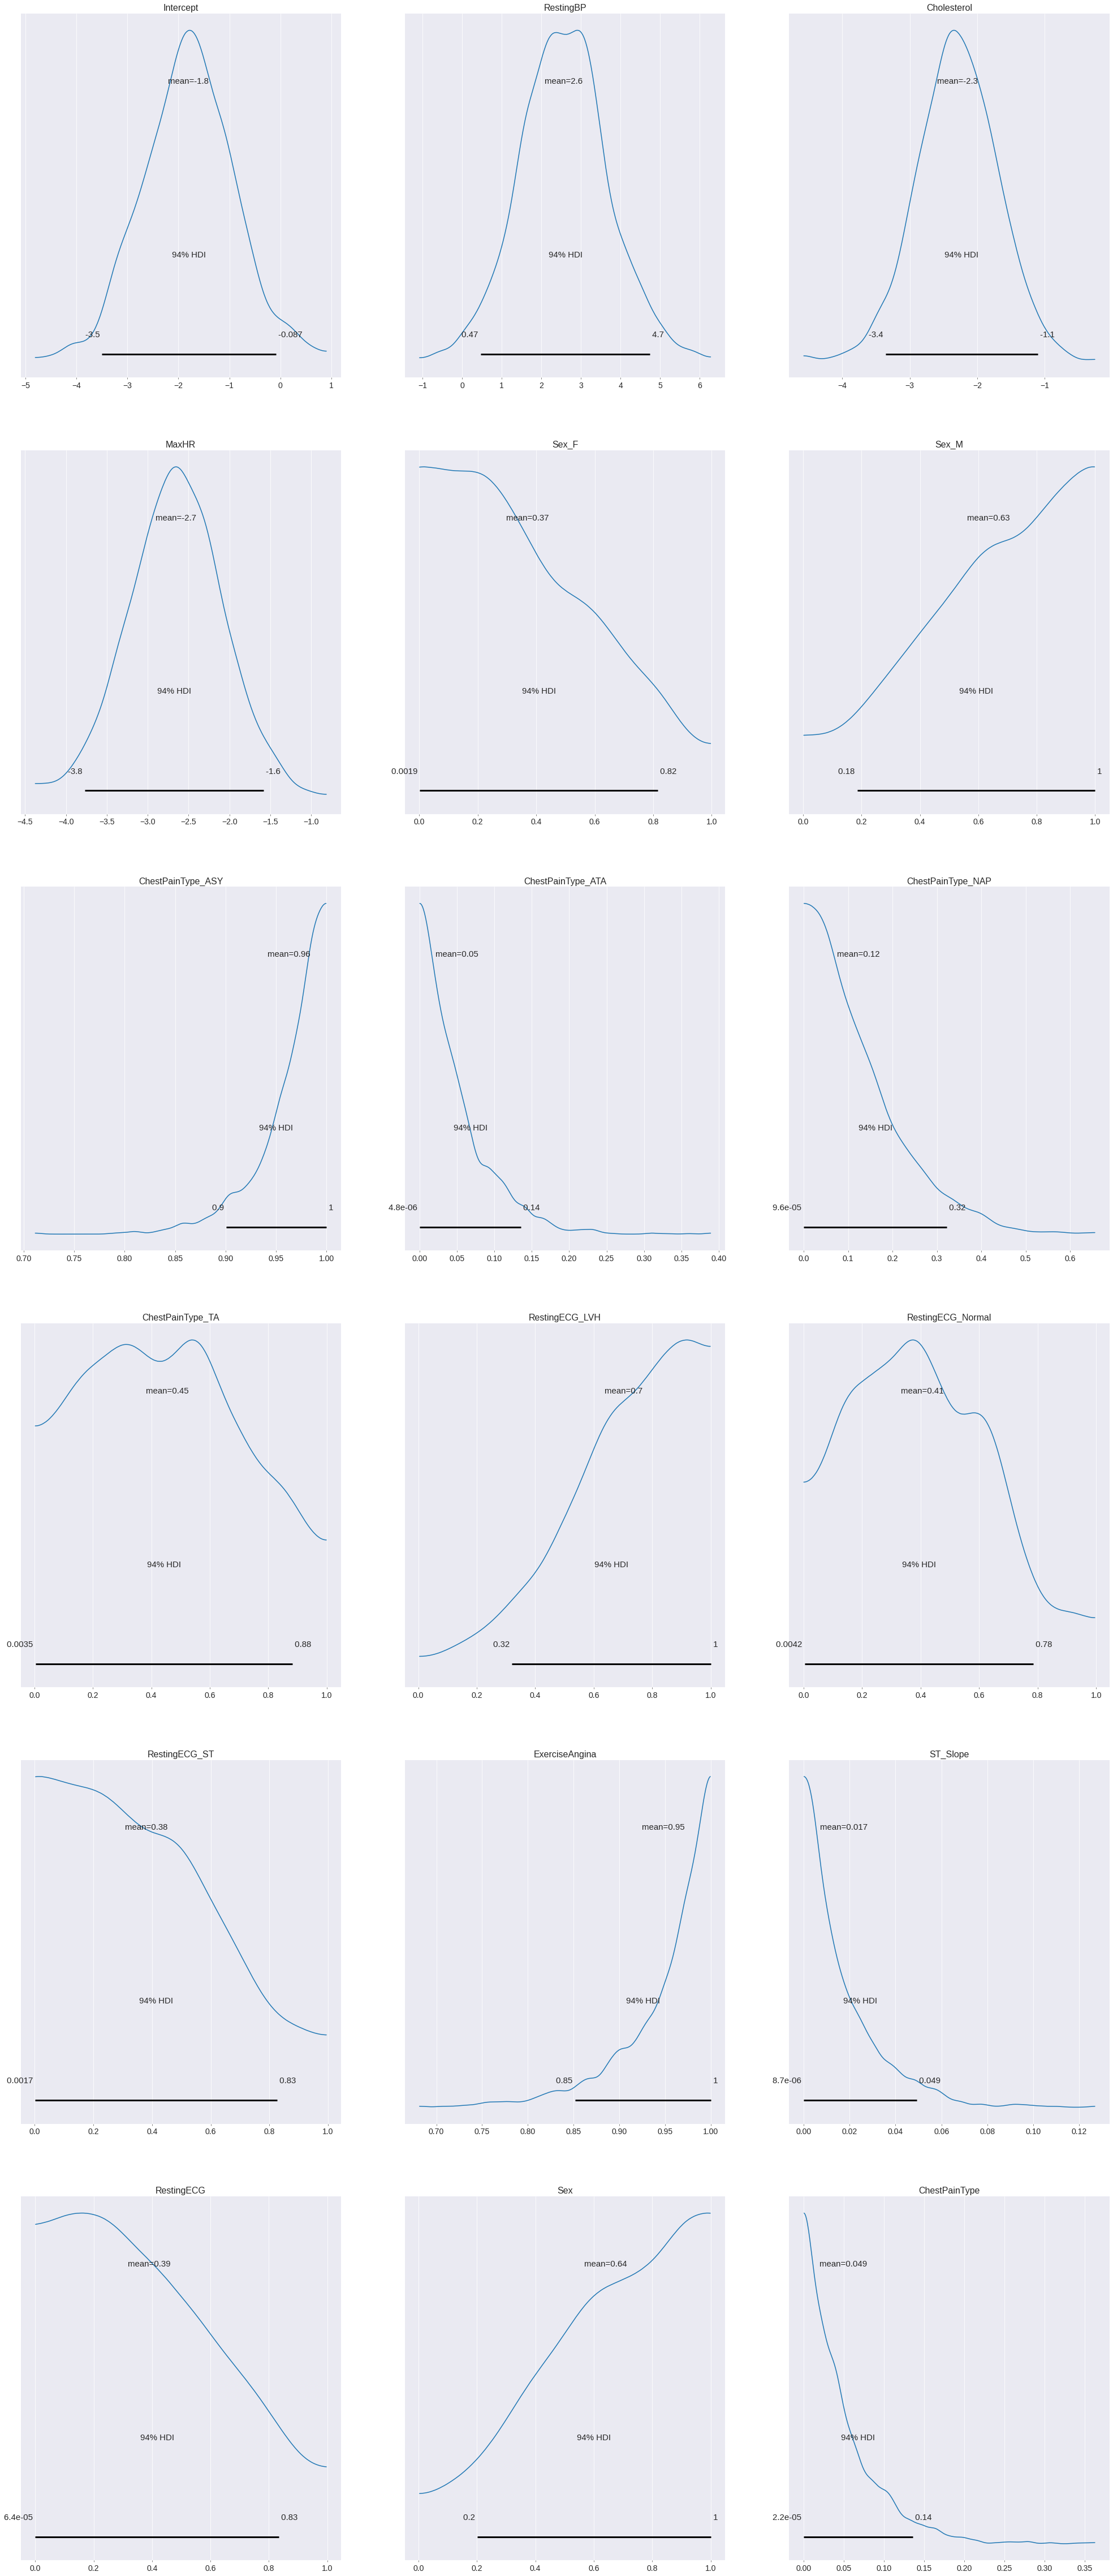

In [ ]:
pm.plot_posterior(trace_log);

Got error No model on context stack. trying to find log_likelihood in translation.


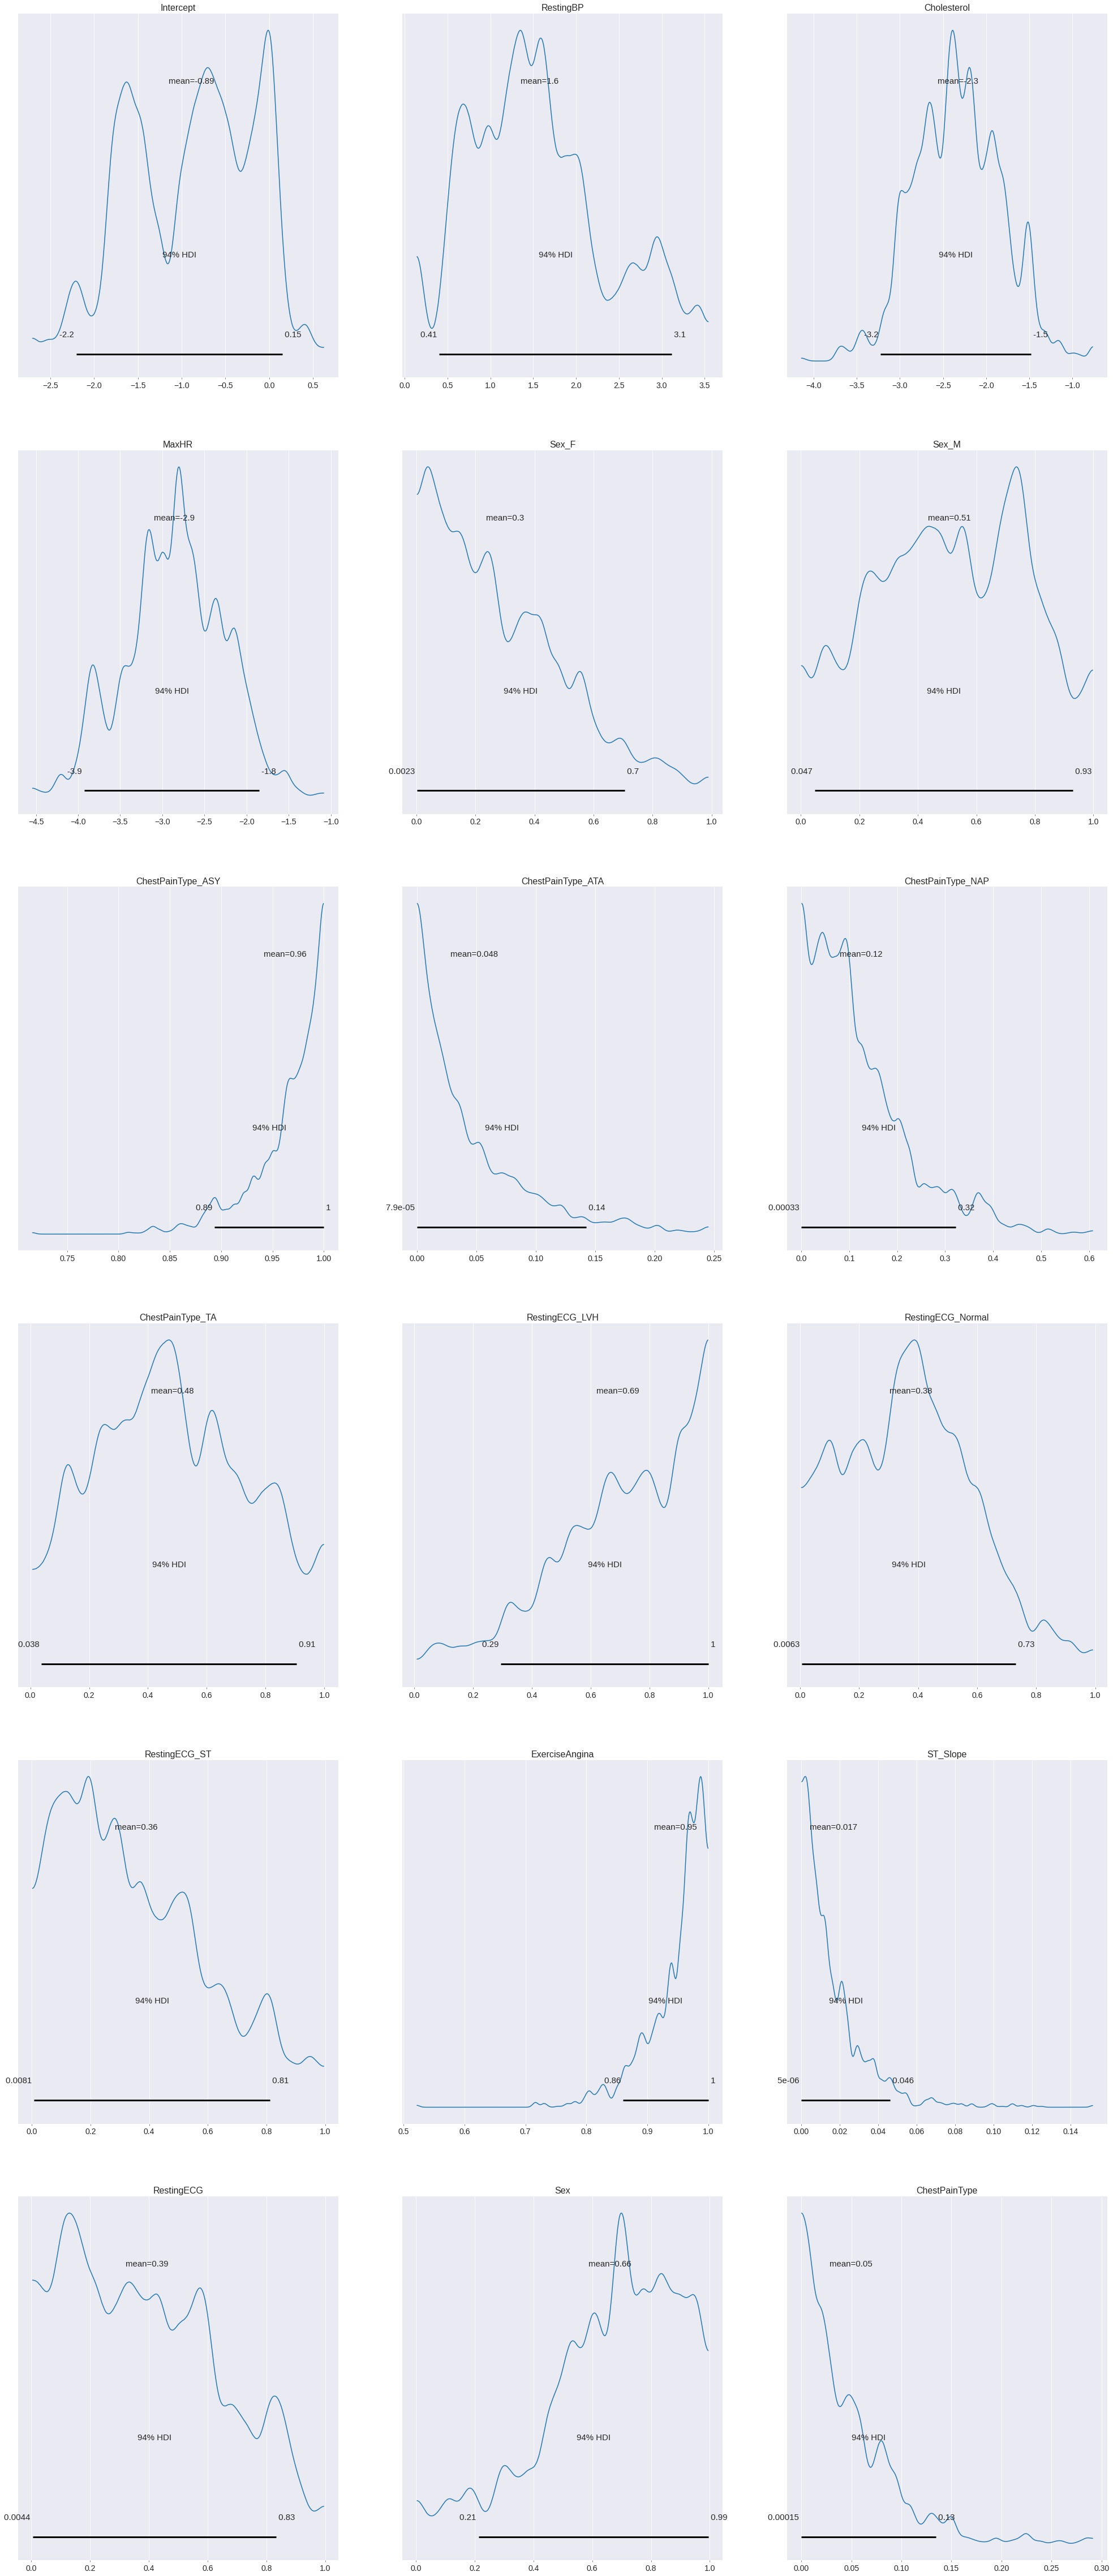

In [21]:
pm.plot_posterior(trace_log_MH);

In [22]:
pm.summary(trace_log)

Got error No model on context stack. trying to find log_likelihood in translation.
arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.800,0.897,-3.497,-0.087,0.031,0.022,862.0,1081.0,NaN
RestingBP,2.563,1.119,0.469,4.746,0.034,0.024,1049.0,1009.0,NaN
Cholesterol,-2.294,0.595,-3.358,-1.105,0.011,0.008,3015.0,1381.0,NaN
MaxHR,-2.655,0.574,-3.772,-1.580,0.012,0.009,2323.0,1289.0,NaN
Sex_F,0.370,0.251,0.002,0.815,0.006,0.004,1990.0,1182.0,NaN
Sex_M,0.634,0.253,0.185,0.999,0.006,0.004,1970.0,935.0,NaN
ChestPainType_ASY,0.963,0.034,0.901,1.000,0.001,0.000,2309.0,942.0,NaN
ChestPainType_ATA,0.050,0.047,0.000,0.136,0.001,0.001,2223.0,1116.0,NaN
ChestPainType_NAP,0.124,0.104,0.000,0.322,0.002,0.002,2164.0,979.0,NaN
ChestPainType_TA,0.454,0.260,0.003,0.883,0.005,0.004,2127.0,1088.0,NaN


In [23]:
pm.summary(trace_log_MH)

Got error No model on context stack. trying to find log_likelihood in translation.
arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.891,0.707,-2.203,0.151,0.277,0.206,7.0,18.0,NaN
RestingBP,1.573,0.779,0.405,3.114,0.265,0.194,9.0,50.0,NaN
Cholesterol,-2.330,0.499,-3.224,-1.484,0.068,0.048,56.0,170.0,NaN
MaxHR,-2.857,0.584,-3.926,-1.850,0.241,0.181,6.0,91.0,NaN
Sex_F,0.300,0.224,0.002,0.705,0.024,0.017,88.0,331.0,NaN
Sex_M,0.508,0.253,0.047,0.930,0.044,0.033,32.0,156.0,NaN
ChestPainType_ASY,0.963,0.036,0.894,1.000,0.002,0.001,274.0,147.0,NaN
ChestPainType_ATA,0.048,0.049,0.000,0.143,0.002,0.002,343.0,312.0,NaN
ChestPainType_NAP,0.124,0.102,0.000,0.322,0.005,0.004,373.0,594.0,NaN
ChestPainType_TA,0.483,0.248,0.038,0.906,0.012,0.009,420.0,499.0,NaN


In [24]:
def evaluate_trace(trace, data, print_model = False):
    means_dict = {}
    std_dict = {}
    
    for var in trace.varnames:
        means_dict[var] = np.mean(trace[var])
        std_dict[var] = np.std(trace[var])
    
    model = 'logit = %0.4f + ' % np.mean(means_dict['Intercept'])
    
    for var in data.columns:
        model += '%0.4f * %s + ' % (means_dict[var], var)
    
    model = ' '.join(model.split(' ')[:-2])
    if print_model:
        print('Final Equation: \n{}'.format(model))
    
    return means_dict, std_dict

In [25]:
means_dict, std_dict = evaluate_trace(trace_log, X_train, print_model=True)


Final Equation: 
logit = -1.8003 + 0.3695 * Sex_F + 0.6339 * Sex_M + 0.9631 * ChestPainType_ASY + 0.0497 * ChestPainType_ATA + 0.1237 * ChestPainType_NAP + 0.4545 * ChestPainType_TA + 0.7018 * RestingECG_LVH + 0.4054 * RestingECG_Normal + 0.3801 * RestingECG_ST + 0.9483 * ExerciseAngina + 0.0174 * ST_Slope + 0.3894 * RestingECG + 0.6402 * Sex + 0.0490 * ChestPainType + 2.5633 * RestingBP + -2.2942 * Cholesterol + -2.6549 * MaxHR


In [26]:
means_dict, std_dict = evaluate_trace(trace_log_MH, X_train, print_model=True)


Final Equation: 
logit = -0.8907 + 0.2998 * Sex_F + 0.5077 * Sex_M + 0.9625 * ChestPainType_ASY + 0.0483 * ChestPainType_ATA + 0.1243 * ChestPainType_NAP + 0.4831 * ChestPainType_TA + 0.6928 * RestingECG_LVH + 0.3760 * RestingECG_Normal + 0.3565 * RestingECG_ST + 0.9463 * ExerciseAngina + 0.0167 * ST_Slope + 0.3929 * RestingECG + 0.6602 * Sex + 0.0498 * ChestPainType + 1.5733 * RestingBP + -2.3304 * Cholesterol + -2.8566 * MaxHR


In [27]:
# Find a single probabilty estimate using the mean value of variables in a trace
def find_probs(trace, data):
    
    # Find the means and std of the variables
    means_dict1, std_dict = evaluate_trace(trace, data)
          
    probs = []
       
    
    # Need an intercept term in the data
    data['Intercept'] = 1
    l_means_dict=dict()
    for c in data.columns:
        
        l_means_dict[c]=means_dict1[c]
    
    data = data[list(l_means_dict.keys())]
    mean_array = np.array(list(l_means_dict.values()))
    # Calculate the probability for each observation in the data
    for _, row in data.iterrows():
        # First the log odds
        logit = np.dot(row, mean_array)
        # Convert the log odds to a probability
        probability = 1 / (1 + np.exp(-logit))
        probs.append(probability)
        
    return probs

In [28]:
blr_probs = find_probs(trace_log, X_test.copy())

# Threshold the values at 0.5
predictions = (np.array(blr_probs) > 0.5)
calc_metrics(predictions, y_test)

Accuracy of Model: 80.07%
F1 Score of Model: 0.8265


In [29]:
blr_probs = find_probs(trace_log_MH, X_test.copy())

# Threshold the values at 0.5
predictions = (np.array(blr_probs) > 0.5)
calc_metrics(predictions, y_test)

Accuracy of Model: 78.62%
F1 Score of Model: 0.8139


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e2e650fd0>,
      dtype=object)

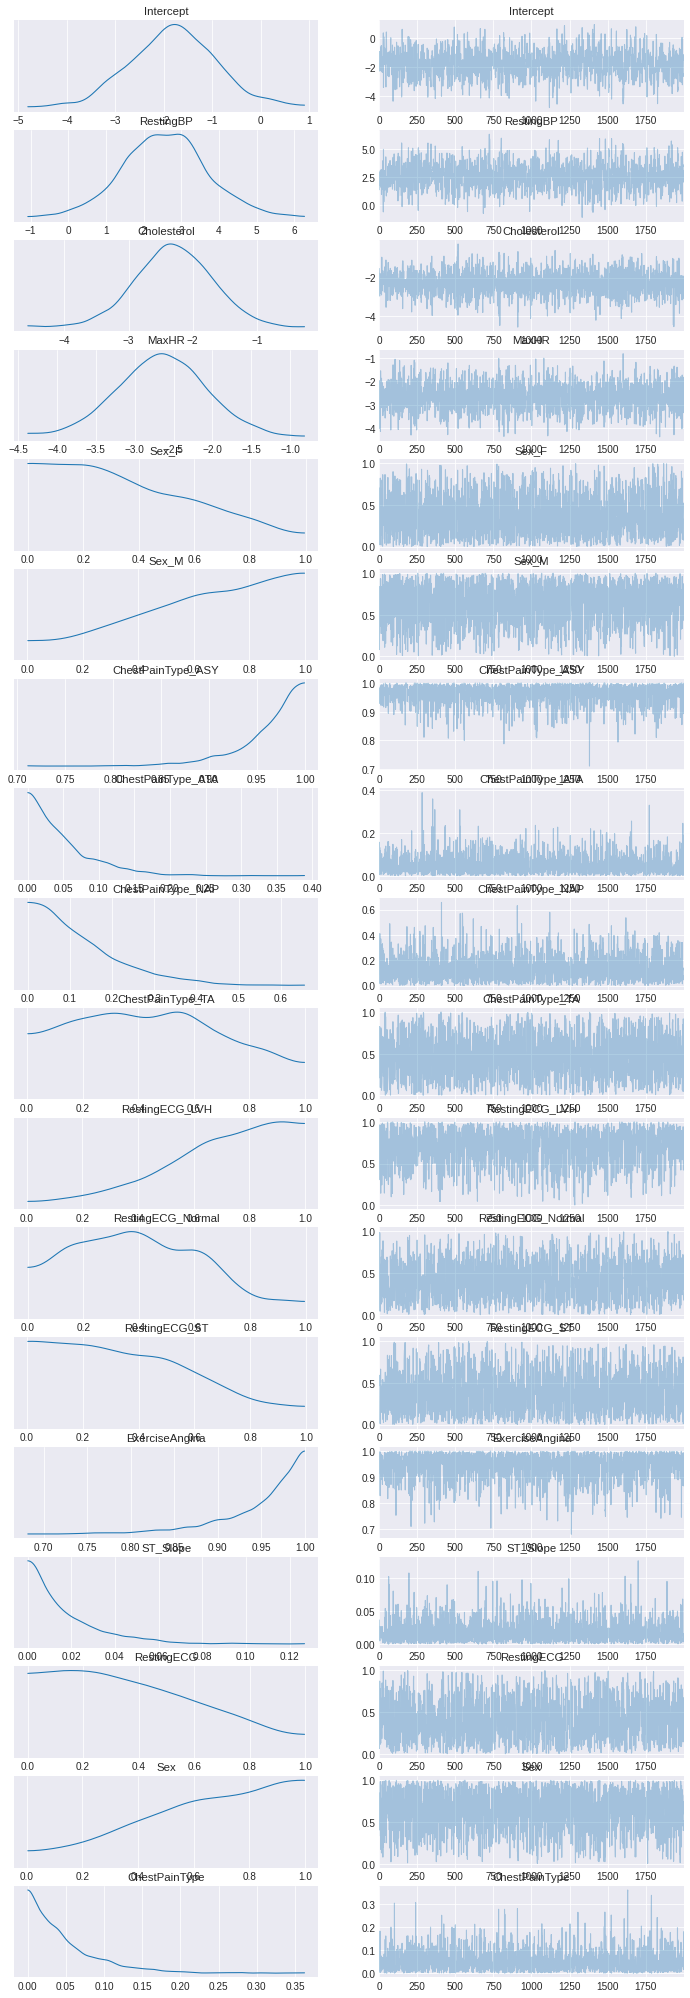

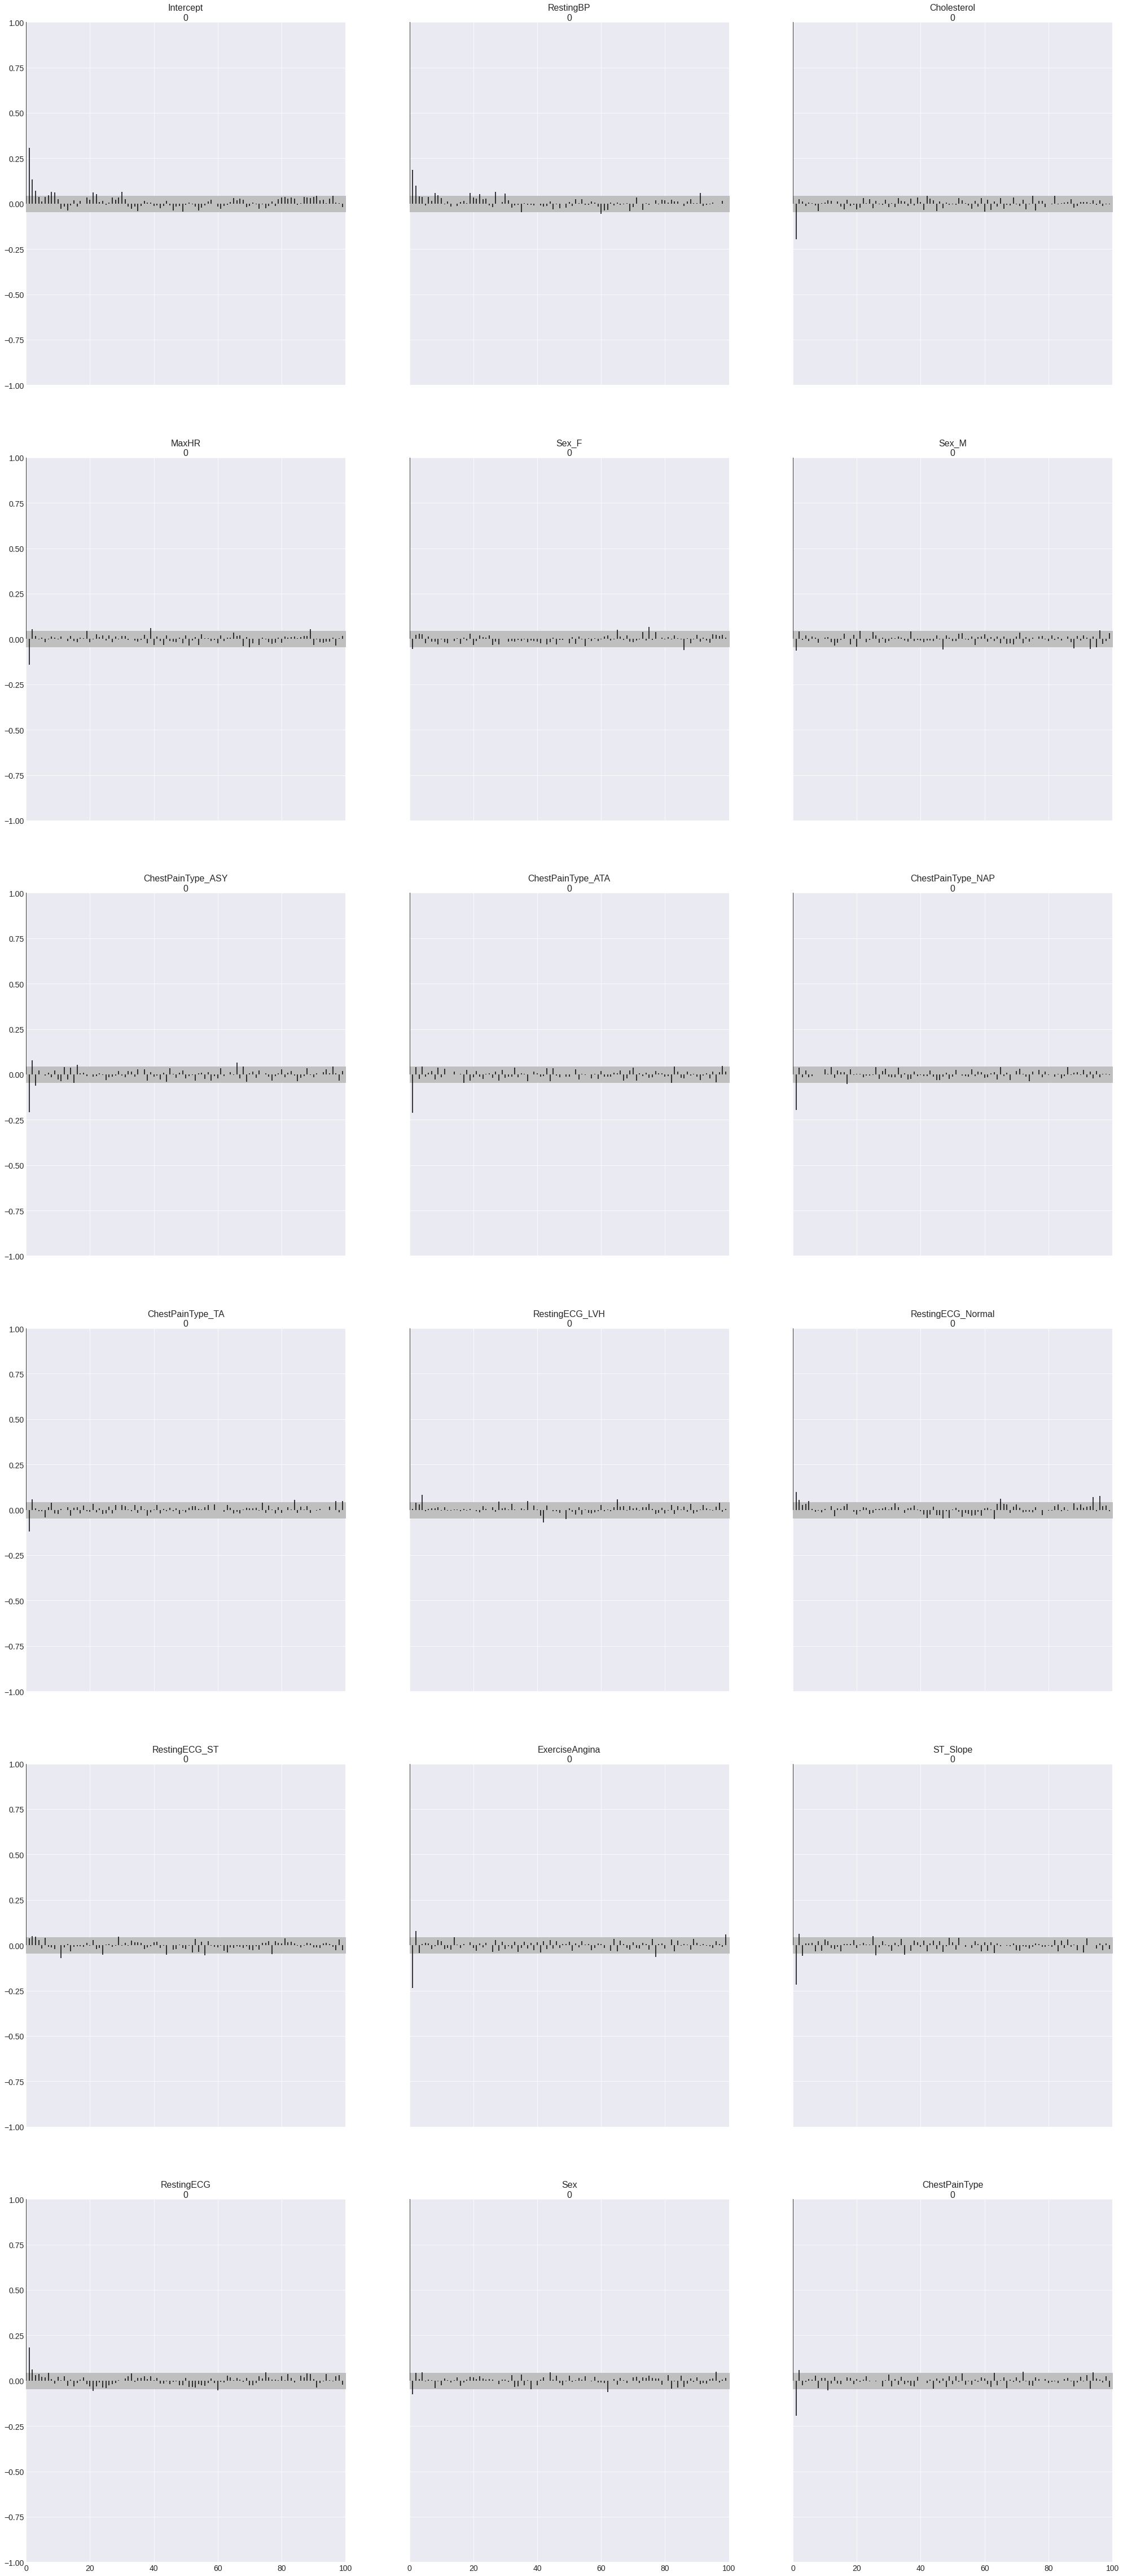

In [30]:
pm.traceplot(trace_log)
pm.autocorrplot(trace_log)

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e33f05950>,
      dtype=object)

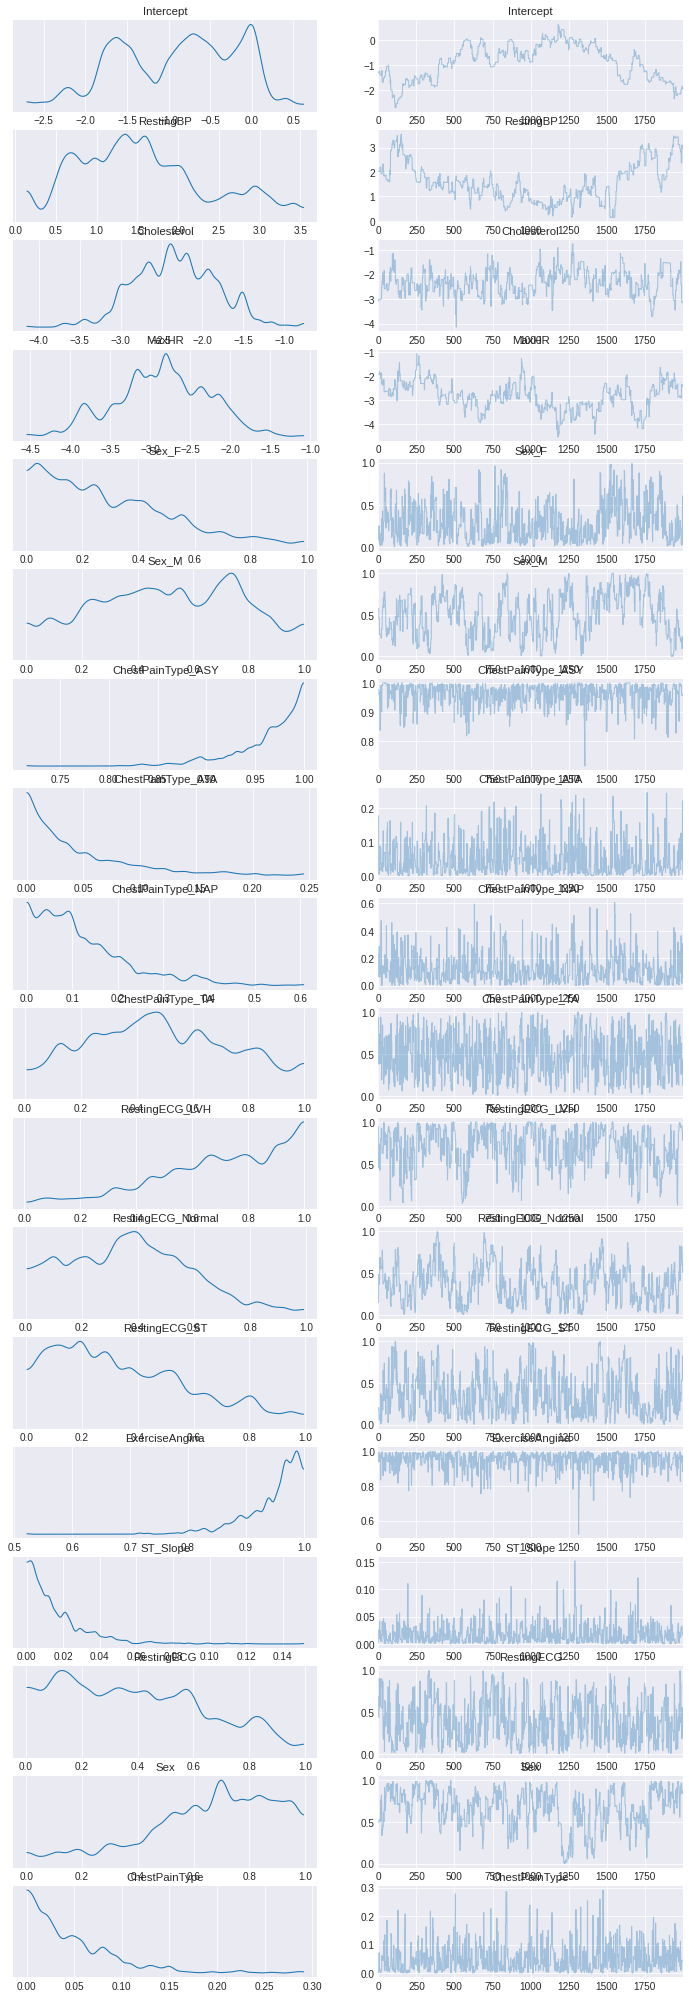

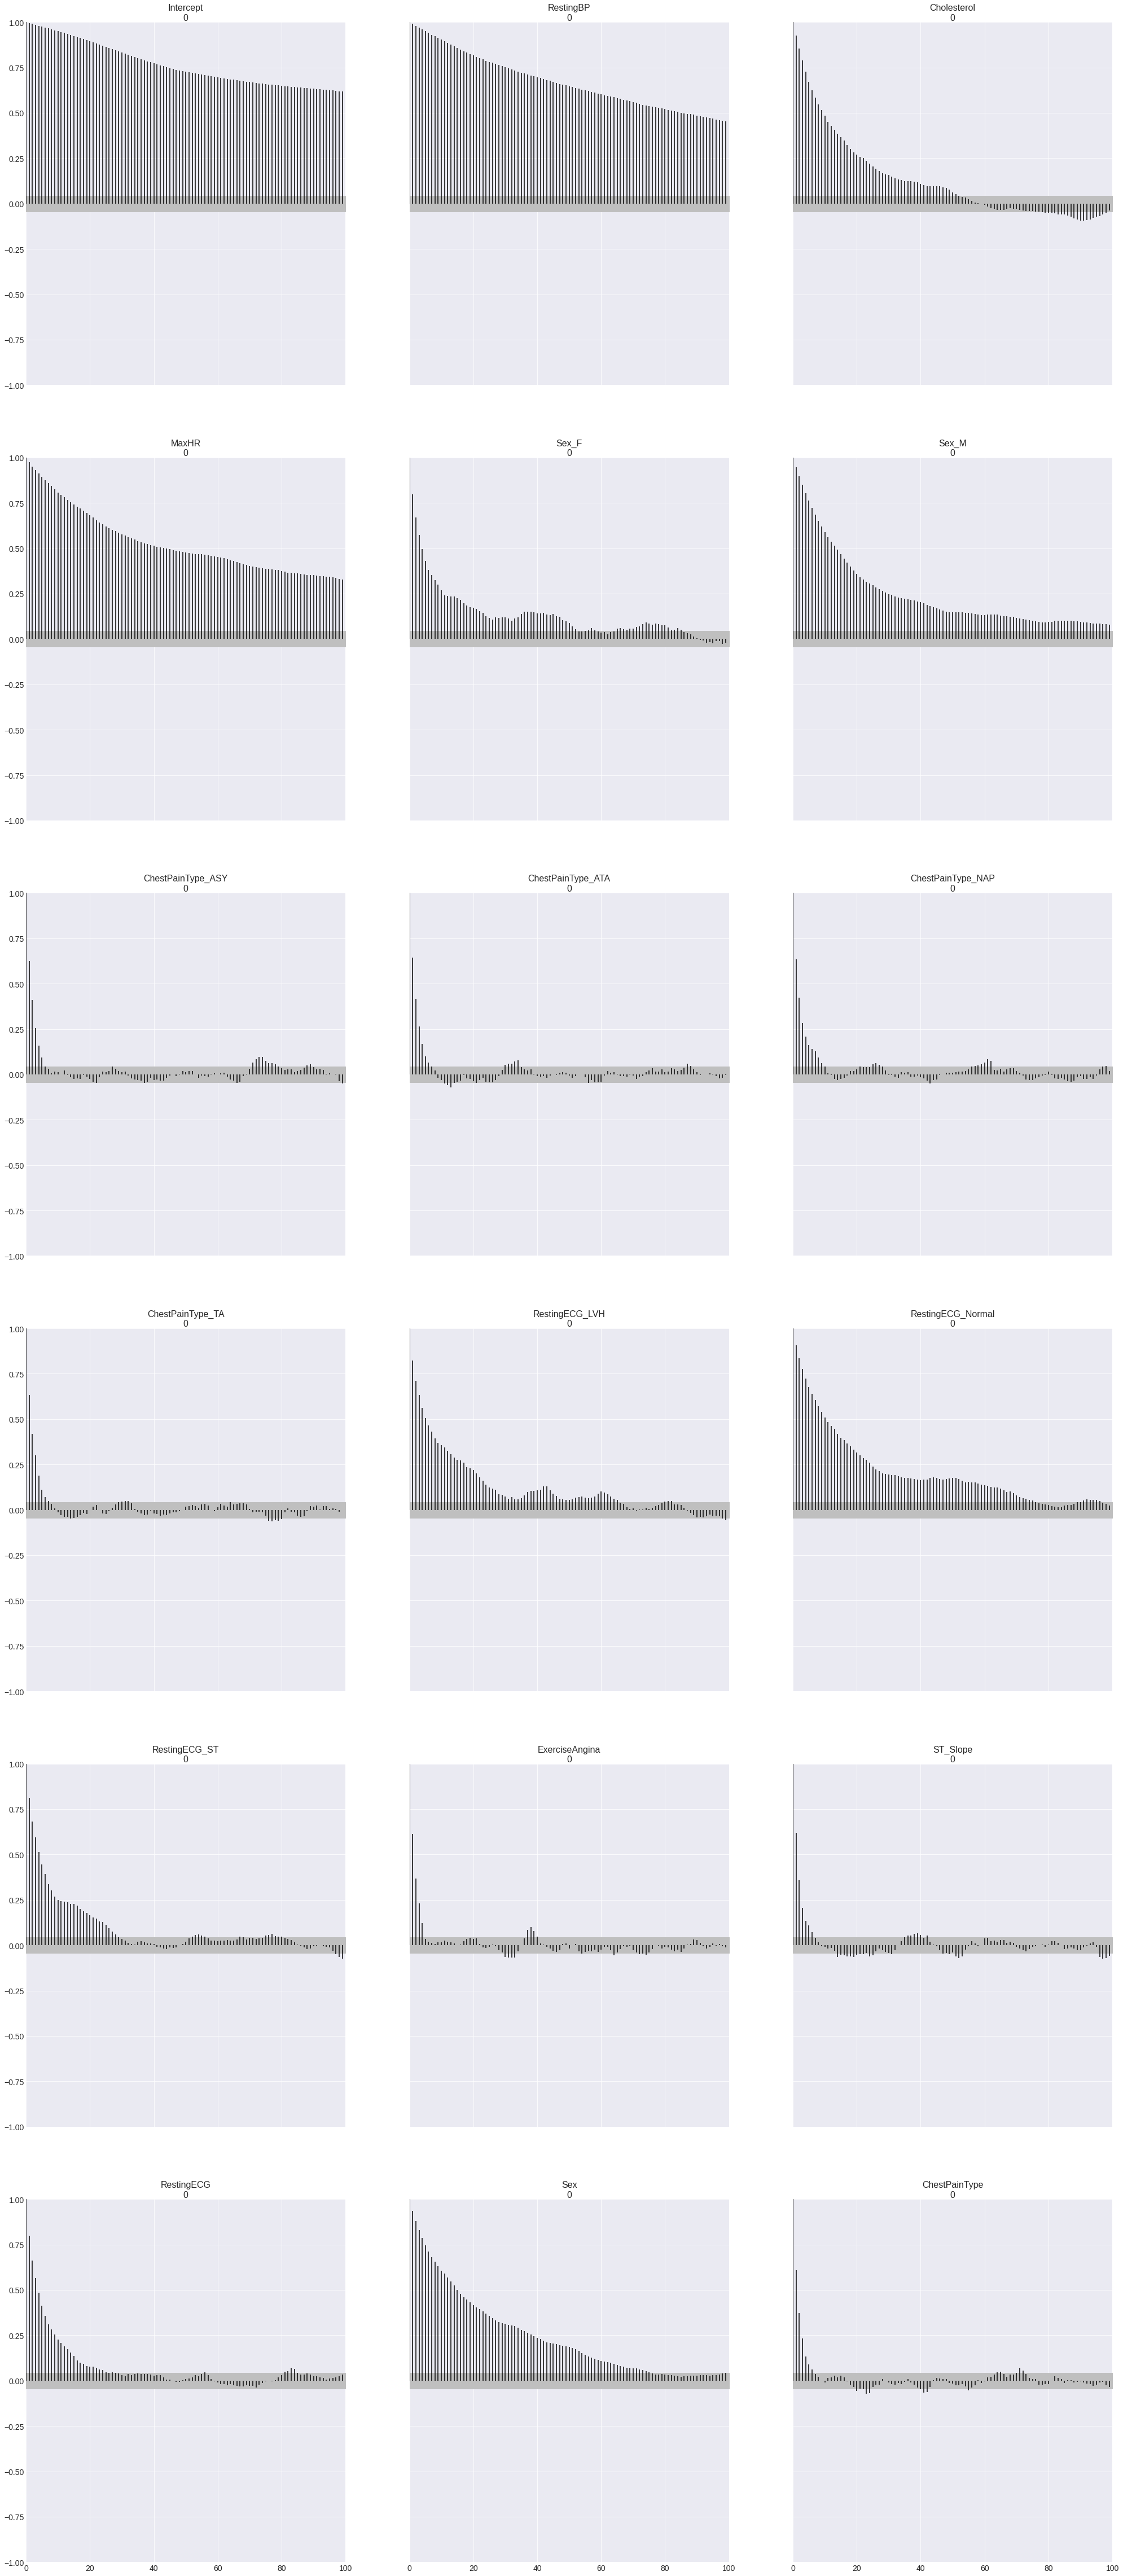

In [31]:
pm.traceplot(trace_log_MH)
pm.autocorrplot(trace_log_MH)

In [32]:
ppc = pm.sample_posterior_predictive(trace_log, samples=1000, model=logistic_model)
np.asarray(ppc['y']).shape

(1000, 642)

In [34]:
ppc_MH = pm.sample_posterior_predictive(trace_log_MH, samples=1000, model=logistic_model)
np.asarray(ppc_MH['y']).shape

(1000, 642)

In [39]:
     
ppc_NU_1 = pm.sample_posterior_predictive(trace_log_NU_1, samples=1000, model=logistic_model1)
np.asarray(ppc_NU_1['y']).shape

(1000, 642)

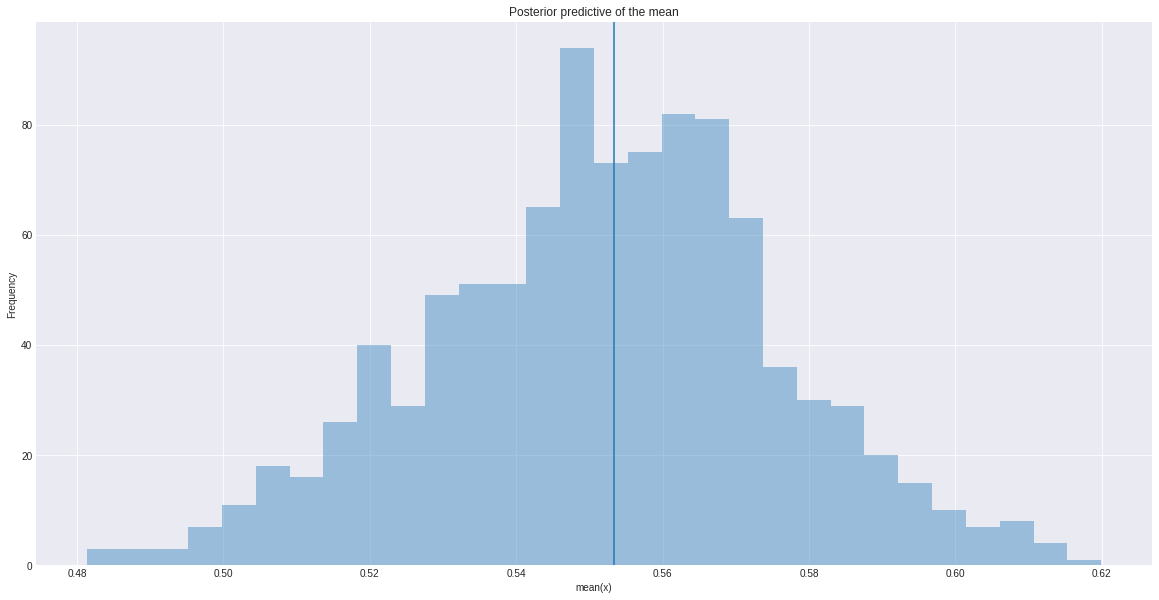

In [35]:
_, ax = plt.subplots(figsize=(20, 10))
ax.hist([y.mean() for y in ppc_MH['y']], bins=30, alpha=0.4)
ax.axvline(y.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

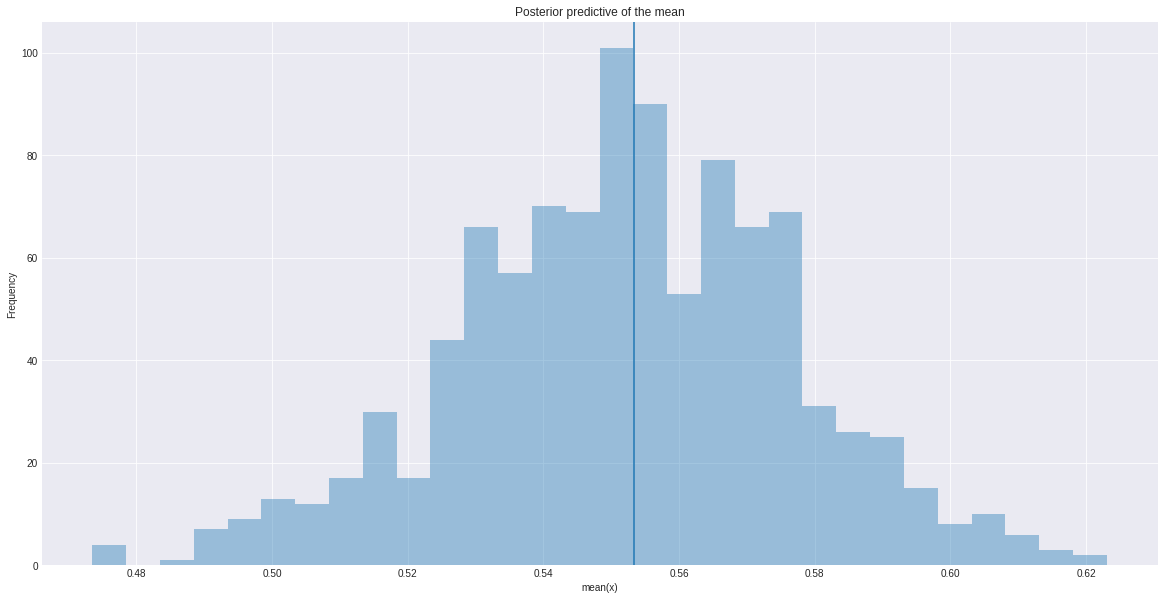

In [40]:
_, ax = plt.subplots(figsize=(20, 10))
ax.hist([y.mean() for y in ppc_NU_1['y']], bins=30, alpha=0.4)
ax.axvline(y.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

# The best result was obtained using NUTs and using two prior feature distributions in GLM mainly Resting BP and Cholestrol as shown in the above chart. 
# as you can see the data distribution and the posterior distribution line have almost overlapped showing accurate learning of the data distribution that can help generalize this model for learning purposes.

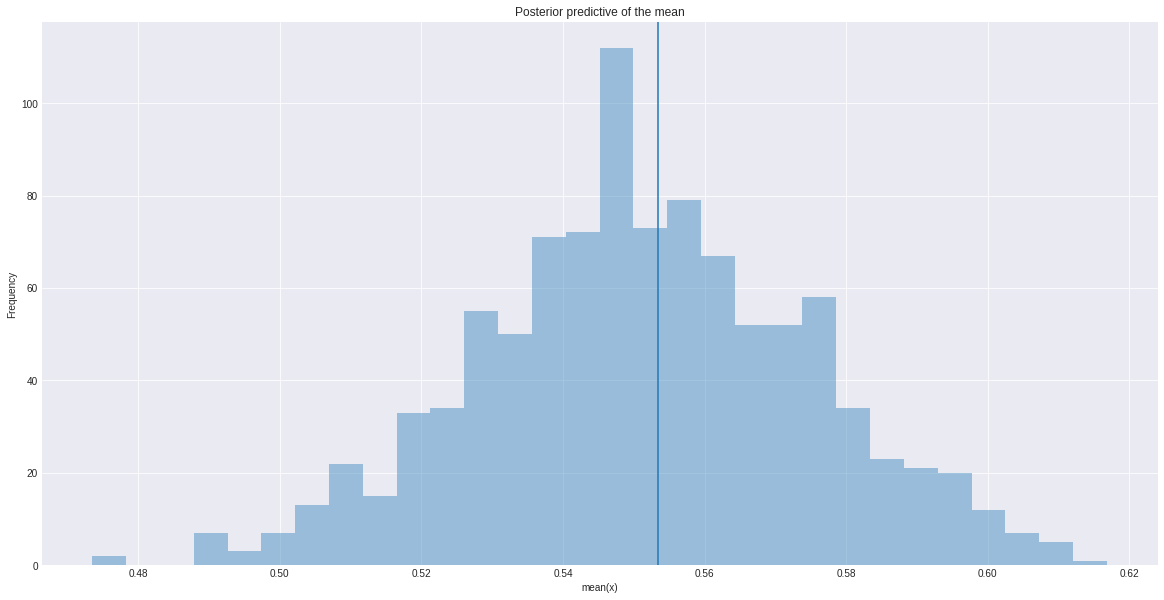

In [36]:
_, ax = plt.subplots(figsize=(20, 10))
ax.hist([y.mean() for y in ppc['y']], bins=30, alpha=0.4)
ax.axvline(y.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');